In [ ]:
import albumentations as A
from albumentations import DualTransform
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch

In [ ]:
def show_image_mask(*img_, split=False):
    plt.figure(figsize=(10,3))
    for i, img in enumerate(list(img_), 1):
#         print(np.shape(img))
        plt.subplot(1,len(img_),i)
    
            
        if type(img) == torch.Tensor:
            if len(img.shape)==4:
                if img.shape[1] == 3:
                    img =  img.flatten(0,1).permute(1,2,0).int().detach().numpy()
                else:
                    img =  img.flatten(0,2).int().detach().numpy()
            elif len(img.shape)==2:
                img = img.int().detach().numpy()
            
 
        
        img = img - img.min()
        if len(np.shape(img)) == 2 or np.shape(img)[-1] == 1:
            
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.show()
    plt.close()

In [ ]:
import os   
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

In [ ]:
file = os.listdir(f'{os.getcwd()}/data/capsule/test/scratch/')
file = np.random.choice(file,size=3, replace=False)
file = [i.split('.')[0] for i in file]
file

['016', '018', '009']

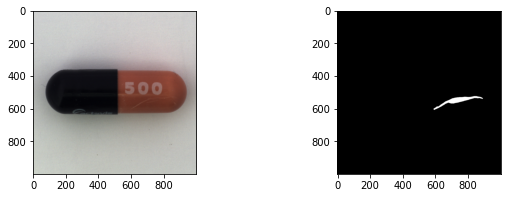

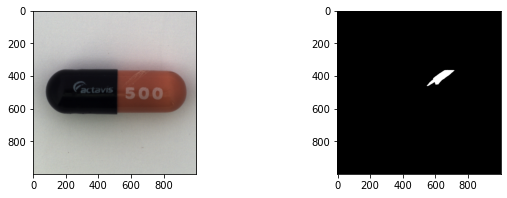

In [ ]:
img_mask_list = []
for i in file[:2]:
    image = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)
    img_mask_list.append((image, mask))
    show_image_mask(image, mask)

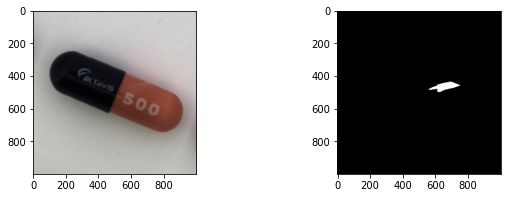

In [ ]:
random.seed(8)
transform = A.Compose([
    A.Rotate((-30, 30), p=1), 
])

transformed  = transform(image=image, mask=mask)
show_image_mask(transformed['image'], transformed['mask'])

In [ ]:
class Crop(DualTransform):
    def __init__(self, x_min=0, y_min=0, x_max=1024, y_max=1024, always_apply=False, p=1.0):
        super(Crop, self).__init__(always_apply, p)
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max

    def apply(self, img, **params):
        return A.crop(img, x_min=self.x_min, y_min=self.y_min, x_max=self.x_max, y_max=self.y_max)


In [ ]:
class mask_CutMix(DualTransform):
    def __init__(self, img_mask_list, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.img_lis, self.mask_lis = zip(*img_mask_list)
        self.choice = np.random.choice(range(len(self.img_lis)),size=1, replace=False)
        self.seed = 1000
        
    def apply(self, img, **params):
        a = self.choice[0]
#         a = choice[0]
#         b = choice[1]
#         print(a,b)
        source_center = self.find_objects_contours(self.mask_lis[a])
        points, _ = self.center_to_4point(self.mask_lis[a], source_center, 256)
        
        target_image = img
        if len(np.shape(img)) == 2:
            source_image = self.mask_lis[a]
        else:
            source_image = self.img_lis[a]
            self.seed = np.random.choice(range(10000),size=1)[0]
        
    
        x_min, y_min, x_max, y_max = points
        target_image = target_image.copy()
        piece = source_image[y_min:y_max, x_min:x_max]
        
        
        transform = A.Compose([
                A.Rotate((-30, 30), p=1), 
                A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
                A.HorizontalFlip(p=0.5),
            ])
        random.seed(self.seed)
        transformed  = transform(image=piece)

        
        target_image[y_min:y_max, x_min:x_max] = transformed['image']
        return target_image
        
    def find_objects_contours(self, mask):
        thresh = mask
        contours, hier = \
            cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        np.shape(contours)

        center = np.array(contours).reshape(-1,2)
        center = center.mean(axis=0)
        return center

    def center_to_4point(self, mask, arr, side_width, pad=None):
        limit = len(mask)
        points = [0]*4

        if not pad:
            pad = 0
        value = side_width/2+pad    
        for i in arr:
            if side_width+2*pad > limit:
                print(side_width+2*pad)
                raise ValueError('not enough')
            if i > limit:
                raise ValueError('not include')

        for i in range(len(points)):
            if i in [0,1]:
                if arr[i%2] - value < 0:
                    points[i] = 0
                    points[i+2] += np.abs(arr[i%2] - value)
                else:
                    points[i] = arr[i%2]-value
            if i in [2,3]:
                if arr[i%2]+value > limit:
                    print(arr[i%2]+value)
                    points[i] = len(mask)
                    points[i-2] -= np.abs(limit - arr[i%2] - value)
                else:
                    points[i] = arr[i%2]+value
        points = np.round(points).astype(int) 
        x_min, y_min, x_max, y_max = points
        return points, mask[y_min:y_max, x_min:x_max]


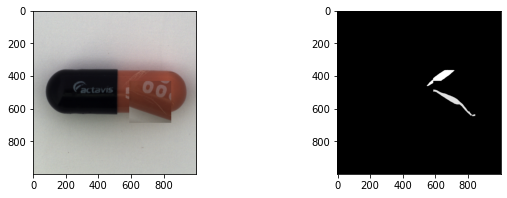

In [ ]:
transform = A.Compose([
    mask_CutMix(img_mask_list),
#     Crop(x_max=1000, y_max=1000)
])

transformed  = transform(image=image, mask=mask)
show_image_mask(transformed['image'], transformed['mask'])